# Relax Challenge

The data is available as two attached CSV files:
 
takehome_user_engagement.csv
takehome_users.csv


The data has the following two tables:

1] A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:

    ● name: the user's name

    ● object_id: the user's id

    ● email: email address

    ● creation_source: how their account was created. This takes on one
    of 5 values:

        ○ PERSONAL_PROJECTS: invited to join another user's personal workspace

        ○ GUEST_INVITE: invited to an organization as a guest (limited permissions)

        ○ ORG_INVITE: invited to an organization (as a full member)

        ○ SIGNUP: signed up via the website

        ○ SIGNUP_GOOGLE_AUTH: signed up using Google

        Authentication (using a Google email account for their login
        id)

    ● creation_time: when they created their account

    ● last_session_creation_time: unix timestamp of last login

    ● opted_in_to_mailing_list: whether they have opted into receiving
    marketing emails

    ● enabled_for_marketing_drip: whether they are on the regular
    marketing email drip

    ● org_id: the organization (group of users) they belong to

    ● invited_by_user_id: which user invited them to join (if applicable).


2] A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.
 
We suggest spending 1-2 hours on this, but you're welcome to spend more or less. 

Please send us a brief writeup of your findings (the more concise, the better ­­ no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach.

Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.


### Create a model to predict user adoption:

- An adopted user is being defined as having logged in 3 times during any seven day period
- identify which factors predict future user adoption
- write up findings
- were there any factors that I considered but did not explore?

In [1]:
# libraries
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
# load data tables
engagement = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv', encoding = 'latin-1')

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### USERS

In [5]:
# rename object_id to user_id
users = users.rename(columns={'object_id': 'user_id','last_session_creation_time':'last_session_creation_time_unix'})

In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   user_id                          12000 non-null  int64  
 1   creation_time                    12000 non-null  object 
 2   name                             12000 non-null  object 
 3   email                            12000 non-null  object 
 4   creation_source                  12000 non-null  object 
 5   last_session_creation_time_unix  8823 non-null   float64
 6   opted_in_to_mailing_list         12000 non-null  int64  
 7   enabled_for_marketing_drip       12000 non-null  int64  
 8   org_id                           12000 non-null  int64  
 9   invited_by_user_id               6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [7]:
# new column for human readable timestamps
users.real_time_last_session = pd.to_datetime(users.last_session_creation_time_unix, unit='s')

/var/folders/70/gq6zfpsx5rg7k0vsvcbg70_40000gn/T/ipykernel_42288/3221648097.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  users.real_time_last_session = pd.to_datetime(users.last_session_creation_time_unix, unit='s')


In [8]:
users.user_id.nunique()

12000

In [9]:
users.email.nunique()

11980

In [10]:
# there are some duplicate emails... who are they?
users.groupby(['email'])['user_id'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(25)

,email,count
9993,ThomasBrandt@gmail.com,2
10177,TomSchiffer@gmail.com,2
5572,KerstinNeudorf@gmail.com,2
10321,UlrikeGerste@gmail.com,2
6765,MandySchroder@gustr.com,2
6083,LeonieDuerr@gmail.com,2
7081,MarkoSeiler@yahoo.com,2
4450,JaninaSankt@gmail.com,2
5672,KlausMueller@gustr.com,2
5811,LasseLNrgaard@gmail.com,2


In [11]:
users.creation_source.nunique()

5

In [12]:
# this should be 1, 0
users.enabled_for_marketing_drip.unique()

array([0, 1])

In [13]:
# this should also be 1,0
users.opted_in_to_mailing_list.unique()

array([1, 0])

In [14]:
# explore
users.org_id.describe()

count    12000.000000
mean       141.884583
std        124.056723
min          0.000000
25%         29.000000
50%        108.000000
75%        238.250000
max        416.000000
Name: org_id, dtype: float64

In [15]:
#explore
users.invited_by_user_id.describe()

count     6417.000000
mean      5962.957145
std       3383.761968
min          3.000000
25%       3058.000000
50%       5954.000000
75%       8817.000000
max      11999.000000
Name: invited_by_user_id, dtype: float64

In [16]:
# nulls
users.isna().sum()

user_id                               0
creation_time                         0
name                                  0
email                                 0
creation_source                       0
last_session_creation_time_unix    3177
opted_in_to_mailing_list              0
enabled_for_marketing_drip            0
org_id                                0
invited_by_user_id                 5583
dtype: int64

In [17]:
# invited by user id could be filled with a fake user id, is user id 0 available?
users.user_id.min()

1

In [18]:
# fill missing invited by with 0
users.invited_by_user_id = users.invited_by_user_id.fillna(0)

### Engagement

In [19]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [20]:
# the engagement dataframe is of logins, so is the visited column all 1? 
# as in only every entry is a login or a visit?
engagement.visited.unique()

array([1])

#### we can now sum the visit column to indicate visits per time period

In [21]:
# engagement time_stamp as datetime type
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [22]:
# change index to time_stamp so .rolling() can filter a time period instead of number of rows
engagement = engagement.set_index('time_stamp')

In [23]:
# filter by user, sum visits for 7 day periods
engagement = pd.DataFrame(engagement.groupby(['user_id'])['visited'].rolling('7D').sum())

In [24]:
# we were told that adopted users were people who visited 3 times during a weekspan
# trim this df down to just those users
engagement = engagement[engagement['visited'] >= 3]

In [25]:
# reset_index to undo the groupby so we can access the user_id column again
engagement = engagement.reset_index()

In [27]:
# create a list of adopted users
adopted_users = list(engagement['user_id'].unique())

In [28]:
len(adopted_users)

1602

### create adopted user column

In [30]:
# define a function to label users adopted 1, or not 0
def adoption(entry):
    
    # label adopted 
    # adopted_users is a list of the adopted users user ids
    if entry['user_id'] in adopted_users:
        return 1
    
    # not adopted
    else:
        return 0

In [31]:
# create a new column for pricing category
users['adopted_user'] = users.apply(lambda x: adoption(x), axis=1)

### Identify which factors predict future user adoption.

In [35]:
# import machine learning libraries

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

In [41]:
# look at columns to identify x and y
users.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time_unix', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted_user'],
      dtype='object')

In [42]:
users.tail()

,user_id,creation_time,name,email,creation_source,last_session_creation_time_unix,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,0.0,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,0.0,0
11999,12000,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,1.390727e+09,0,1,0,0.0,0


In [49]:
# nulls?
users.isna().sum()

user_id                               0
creation_time                         0
name                                  0
email                                 0
creation_source                       0
last_session_creation_time_unix    3177
opted_in_to_mailing_list              0
enabled_for_marketing_drip            0
org_id                                0
invited_by_user_id                    0
adopted_user                          0
hot_creation_source                   0
dtype: int64

In [50]:
# fill those missing timestamps with 0, however if the last session is missing does that mean they never visited?
users.last_session_creation_time_unix = users.last_session_creation_time_unix.fillna(0)

In [43]:
# I forgot about creation source!
users.creation_source.unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [44]:
# simple one hot encode for creation_source
def rename_CS(x):
    if 'GUEST_INVITE' in x:
        return 1
    elif 'ORG_INVITE' in x:
        return 2
    elif 'SIGNUP' in x:
        return 3
    elif 'PERSONAL_PROJECTS' in x:
        return 4
    elif 'SIGNUP_GOOGLE_AUTH' in x:
        return 5

In [45]:
# new column for creation source numeric type
users['hot_creation_source'] = users['creation_source'].apply(lambda x: rename_CS(x))

In [237]:
# create columns for date info
users[["creation_time_year", "creation_time_month", "creation_time_day"]] = users["creation_time"].str.split("-", expand = True)

In [247]:
# clean up day column
users[['creation_time_day', 'time']] = pd.DataFrame(users['creation_time_day'].tolist(), index= users.index)

In [250]:
users[["creation_time_year", "creation_time_month", "creation_time_day"]] = users[["creation_time_year", "creation_time_month", "creation_time_day"]].astype('int')

In [251]:
users = users.drop(columns=['time'])

## Models

In [252]:
y = users['adopted_user']
x = users.drop(columns=['adopted_user','name','email','creation_source', 'creation_time'])

In [253]:
# create test/ train data sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43)

In [254]:
# random forest classifier, almost out of the box

random_forest_classifier = RandomForestClassifier(n_estimators=1000, criterion='entropy')
model = random_forest_classifier.fit(X_train, y_train)
y_pred = model.predict(X_test)

## metrics

In [255]:
confusion_matrix(y_test, y_pred)

array([[2031,   23],
       [  70,  276]])

In [256]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2054
           1       0.92      0.80      0.86       346

    accuracy                           0.96      2400
   macro avg       0.94      0.89      0.92      2400
weighted avg       0.96      0.96      0.96      2400



#### The model predictions:
Pretty good job at predicting 0, still over predicts 0 giving 1's low recall 

In [288]:
# random forest classifier, with modified weighting 

random_forest_classifier2 = RandomForestClassifier(n_estimators=1000, criterion='entropy', class_weight={0:5,1:1})
model2 = random_forest_classifier2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

In [289]:
confusion_matrix(y_test, y_pred2)

array([[2031,   23],
       [  68,  278]])

In [290]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2054
           1       0.92      0.80      0.86       346

    accuracy                           0.96      2400
   macro avg       0.95      0.90      0.92      2400
weighted avg       0.96      0.96      0.96      2400



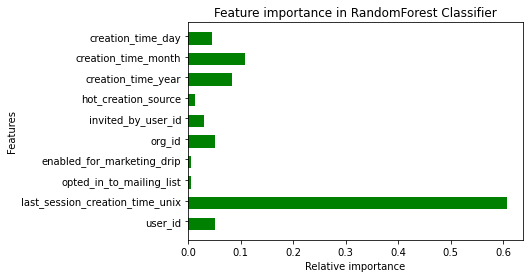

In [291]:
features = model2.feature_importances_

fig, ax = plt.subplots() 
width = 0.6 # the width of the bars 
ind = np.arange(len(features)) # the x locations for the groups

ax.barh(ind, features, width, color="green")
ax.set_yticks(ind+width/5)

ax.set_yticklabels(x, minor=False, fontsize=10)
plt.title('Feature importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('Features') 
plt.show()

# KNN

In [261]:
from sklearn.neighbors import KNeighborsClassifier

In [292]:
knn_model = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan')
knn_model.fit(X_train, y_train)
preds=knn_model.predict(X_test)

In [293]:
confusion_matrix(y_test, preds)

array([[1944,  110],
       [ 142,  204]])

In [294]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2054
           1       0.65      0.59      0.62       346

    accuracy                           0.90      2400
   macro avg       0.79      0.77      0.78      2400
weighted avg       0.89      0.90      0.89      2400



#### not as good as tree

## thoughts for later:
1. Are duplicate emails the same person?

Creation day, month and year were all great indicators of whether or not someone became an adopted user. There is something about specific times of year that provides optimism for your service, perhaps its the weather or current events